<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_3_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using Convolutional Neural Networks

In this lab, you will look at another way of building your text classification model and this will be with a convolution layer. As you learned in Course 2 of this specialization, convolutions extract features by applying filters to the input. Let's see how you can use that for text data in the next sections.

## Download and prepare the dataset

In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

2023-02-11 19:07:36.674937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 19:07:37.134946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21630 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)


## Build the Model

In Course 2, you were using 2D convolution layers because you were applying it on images. For temporal data such as text sequences, you will use [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) instead so the convolution will happen over a single dimension. You will also append a pooling layer to reduce the output of the convolution layer. For this lab, you will use [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) to get the max value across the time dimension. You can also use average pooling and you will do that in the next labs. See how these layers behave as standalone layers in the cell below.

In [3]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 20
filters = 128
kernel_size = 5

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'filters: {filters}')
print(f'kernel_size: {kernel_size}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)


2023-02-11 19:07:57.470552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600


shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


You can build the model by simply appending the convolution and pooling layer after the embedding layer as shown below.

In [4]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
filters = 128
kernel_size = 5
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
__________________________________________________

In [5]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

Training will take around 30 seconds per epoch and you will notice that it reaches higher accuracies than the previous models you've built.

In [6]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10


2023-02-11 19:08:13.208422: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


98/98 [==============================] - 12s 113ms/step - loss: 0.6054 - accuracy: 0.6651 - val_loss: 0.3996 - val_accuracy: 0.8272
Epoch 2/10
98/98 [==============================] - 5s 54ms/step - loss: 0.2826 - accuracy: 0.8842 - val_loss: 0.2731 - val_accuracy: 0.8856
Epoch 3/10
98/98 [==============================] - 5s 47ms/step - loss: 0.1465 - accuracy: 0.9492 - val_loss: 0.2686 - val_accuracy: 0.8911
Epoch 4/10
98/98 [==============================] - 4s 42ms/step - loss: 0.0639 - accuracy: 0.9858 - val_loss: 0.2894 - val_accuracy: 0.8928
Epoch 5/10
98/98 [==============================] - 4s 41ms/step - loss: 0.0203 - accuracy: 0.9982 - val_loss: 0.3220 - val_accuracy: 0.8936
Epoch 6/10
98/98 [==============================] - 4s 42ms/step - loss: 0.0072 - accuracy: 0.9997 - val_loss: 0.3517 - val_accuracy: 0.8945
Epoch 7/10
98/98 [==============================] - 4s 40ms/step - loss: 0.0034 - accuracy: 0.9999 - val_loss: 0.3766 - val_accuracy: 0.8929
Epoch 8/10
98/98 [====

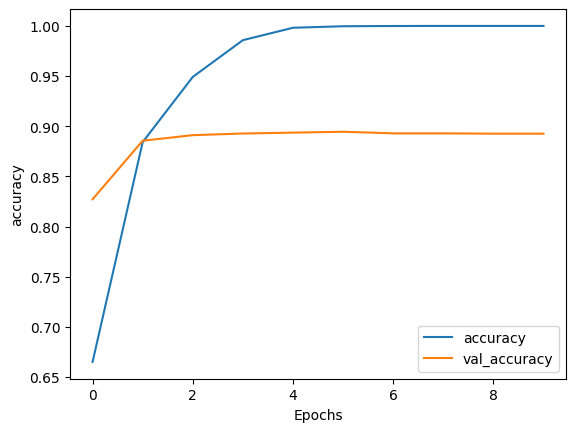

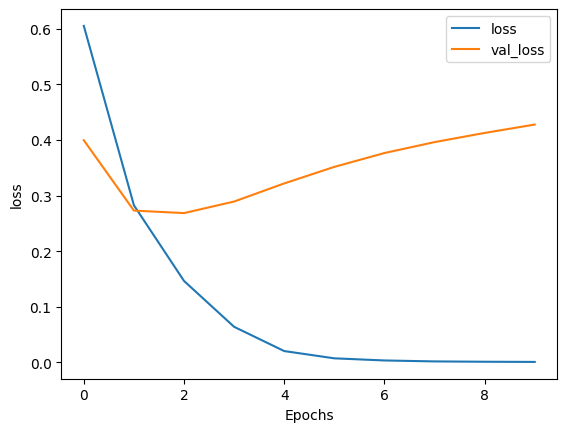

In [7]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

In this lab, you explored another model architecture you can use for text classification. In the next lessons, you will revisit full word encoding of the IMDB reviews and compare which model works best when the data is prepared that way.